In this notebook, we play around with using Capyldi (Capaldi?) to do bulk runs on the whereistheboom.csv dump.

In [1]:
import pandas as pd
import matplotlib as mpl
import numpy as np
import numpy.random as npr
from tqdm import tqdm
import requests
import sys

from geopy.distance import distance

sys.path.append('../../../capyldi')
from capyldi import capyldi

%matplotlib inline

In [2]:
ceasefire_df = pd.read_csv('../data/go_events/ceasefire_chronology.csv', parse_dates=['Date'])
start_date = ceasefire_df.Date[0]
ceasefire_df = ceasefire_df.iloc[1:, :].reset_index(drop=True)
real_dates = set(ceasefire_df.Date)
ceasefire_df['lat_lon'] = ceasefire_df['Lat,Lon'].apply(eval)
del ceasefire_df['Lat,Lon']

In [3]:
base_df = pd.read_csv('../data/instagram/instagram_yemen_user_posts_shrunk.csv',
                      parse_dates=['timestamp'])
del base_df['epoch']
base_df.columns = ['id', 'lat_lon', 'date_col']
base_df['lat_lon'] = base_df.lat_lon.apply(eval)
df = base_df.date_col.value_counts().reset_index()
df.columns = ['date_col', 'count_col']

In [4]:
base_df.shape

(3902571, 3)

In [5]:
import pickle

def haversine(lat_lons_1, lat_lon_2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lons_1 = np.radians([x[1] for x in lat_lons_1])
    lats_1 = np.radians([x[0] for x in lat_lons_1])
    lon_2 = np.radians(lat_lon_2[1])
    lat_2 = np.radians([lat_lon_2[0]])
    
    dlons = lon_2 - lons_1
    dlats = lat_2 - lats_1
    
    a_vals = np.power(np.sin(dlats/2), 2) + np.cos(lats_1) * np.cos(lat_2) * np.power(np.sin(dlons/2), 2)
    c_vals = 2 * np.arcsin(np.sqrt(a_vals))
    return 6367 * c_vals

In [6]:
MAX_R = 160.934

incident_dfs = []
for i in range(ceasefire_df.shape[0]):
    
    def is_in_range(x_vars):
        try:
            return haversine(x_vars, ceasefire_df.loc[i, 'lat_lon']) < MAX_R
        except UnboundLocalError:
            return False
    
    incident_dfs.append(base_df.loc[is_in_range(base_df.lat_lon.values), :])
    print(incident_dfs[-1].shape)
    with open('incident_df_{}.pkl'.format(i), 'wb') as outfile:
        pickle.dump(incident_dfs[-1], outfile)

(5074, 3)
(11313, 3)
(5517, 3)
(11313, 3)
(11316, 3)
(11353, 3)
(11313, 3)
(10691, 3)
(4169, 3)
(4222, 3)
(4171, 3)
(5560, 3)


In [7]:
import pickle
with open('yemen_zones.pkl', 'wb') as outfile:
    pickle.dump(incident_dfs, outfile)

In [8]:
for i in range(len(incident_dfs)):
    incident_dfs[i] = incident_dfs[i].date_col.value_counts().reset_index()
    incident_dfs[i].columns = ['date_col', 'count_col']

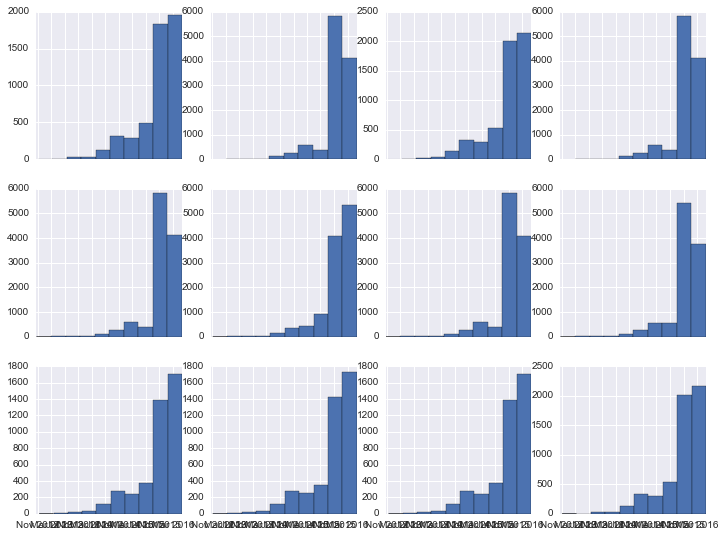

In [15]:
f, axarr = plt.subplots(3, 4, figsize=(12, 9), sharex=True)
for i in range(3):
    for j in range(4):
        incident_dfs[4*i+j].date_col.hist(ax=axarr[i, j])

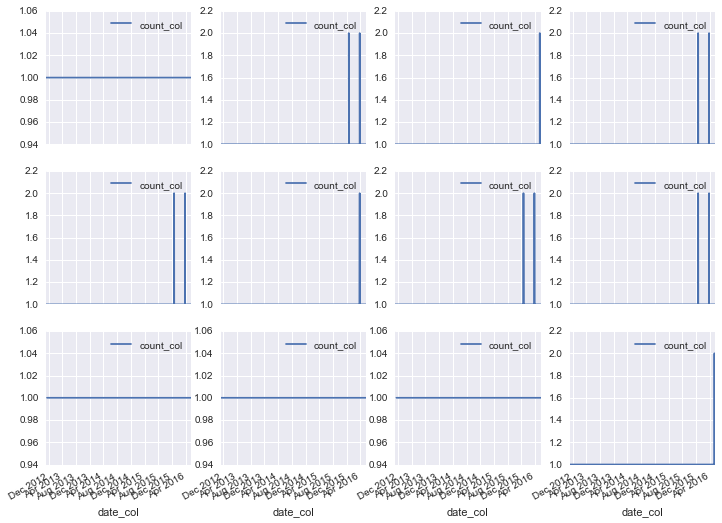

In [14]:
f, axarr = plt.subplots(3, 4, figsize=(12, 9), sharex=True)
for i in range(3):
    for j in range(4):
        incident_dfs[i*4+j].plot(x='date_col', y='count_col', kind='line', ax=axarr[i, j])

---

In [11]:
results = []
for i in range(len(incident_dfs)):
    results.append(capyldi(incident_dfs[i], ['arima']))
    with open('i_df_arima_{}'.format(i), 'wb') as outfile:
        pickle.dump(results[-1], outfile)

Getting time crosstabs:   0%|          | 0/9 [00:00<?, ?it/s]
Analyzing: 0it [00:00, ?it/s]
                             
Analyzing: 0it [00:00, ?it/s]
                             
Analyzing: 0it [00:00, ?it/s]
                             
Analyzing: 0it [00:00, ?it/s]
                             
Analyzing: 0it [00:00, ?it/s]
                             
Analyzing: 0it [00:00, ?it/s]
                             
Analyzing: 0it [00:00, ?it/s]
                             
Analyzing: 0it [00:00, ?it/s]
                             
Analyzing: 0it [00:00, ?it/s]
Getting time crosstabs:   0%|          | 0/9 [00:00<?, ?it/s]
Analyzing: 0it [00:00, ?it/s]
                             
Analyzing: 0it [00:00, ?it/s]
                             
Analyzing: 0it [00:00, ?it/s]
                             
Analyzing: 0it [00:00, ?it/s]
                             
Analyzing: 0it [00:00, ?it/s]
                             
Analyzing: 0it [00:00, ?it/s]
                             
Analyz

In [12]:
import pickle
with open('../data/pickles/results_yemen_zone_arimas.pkl', 'wb') as outfile:
    pickle.dump(results, outfile)